#### Q3 of week 1 Transport Modelling labs

Loading trip data, constructing an origin-destination matrix, and some simple metrics from the data

In [139]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np
from numpy import e
import matplotlib.pyplot as plt


In [ ]:
# reduce down to only origin, destination, and count columns
census = pd.read_csv('ODWP01EW_MSOA.csv')
census = census.loc[:, ['Middle layer Super Output Areas code', 'MSOA of workplace code', 'Count']]

# change column names to be more helpful
census.columns = ['Origin', 'Destination', 'Count']

# group duplicate workplaces
census = census.groupby(['Origin', 'Destination']).sum()

# convert to matrix
od_matrix = census.unstack(fill_value=0)
od_matrix = od_matrix.droplevel(0, axis=1)

# origin/destination totals
o_total = od_matrix.sum(axis=1)
d_total = od_matrix.sum(axis=0)

AttributeError: 'Series' object has no attribute 'columns'

#### Physical geography

Loading MSOA centroids from census data and using it to compute a symmetric distance matrix

In [3]:
census2 = pd.read_csv('UK_census_msoa_stats.csv')
coords = census2.loc[:, ['MSOA Code', 'Longitude', 'Latitude']]

# only use first 100 locations to reduce compute
msoa_codes = coords.loc[:, 'MSOA Code'].to_list()[:100]

distances = pd.DataFrame(index = msoa_codes, columns = msoa_codes)

# this takes a while, ~7200 MSOA regions
for i in msoa_codes:
    # pandas indexing is horrible sometimes
    i_coord = coords.loc[coords.loc[:, 'MSOA Code'] == i, ['Longitude', 'Latitude']].iloc[0].to_list()
    
    distances_temp = []
    
    for j in msoa_codes:
        j_coord = coords.loc[coords.loc[:, 'MSOA Code'] == j, ['Longitude', 'Latitude']].iloc[0].to_list()
        distances_temp.append(geodesic(i_coord, j_coord).km)
    
    distances.loc[i,:] = distances_temp
    # msoa_codes.remove(i)

# save to avoid doing this again
distances.to_csv('MSOA_Distances.csv')
print(distances.iloc[:5, :5])


           E02000001  E02000002 E02000003  E02000004  E02000005
E02000001        0.0  26.712032  26.73206  30.297982  27.003876
E02000002  26.712032        0.0  1.413409   5.138925   2.837226
E02000003   26.73206   1.413409       0.0   4.179012   1.429326
E02000004  30.297982   5.138925  4.179012        0.0   3.366948
E02000005  27.003876   2.837226  1.429326   3.366948        0.0


#### Load distance data and filter origin-destination matrix to only regions for both data

In [4]:
distances = pd.read_csv('MSOA_Distances.csv', index_col=0)

# for some reason not all msoas are represented in origin-destination data
msoa_codes = distances.columns.to_list()[1:]
joint_msoa_codes = [msoa for msoa in msoa_codes if msoa in od_matrix.columns.to_list()]

# keep only data for distances combinations i could be bothered to get
od_reduced = od_matrix.loc[joint_msoa_codes, joint_msoa_codes]



#### Plotting stuff
Restack the matrices to plot a histogram of trips by distance

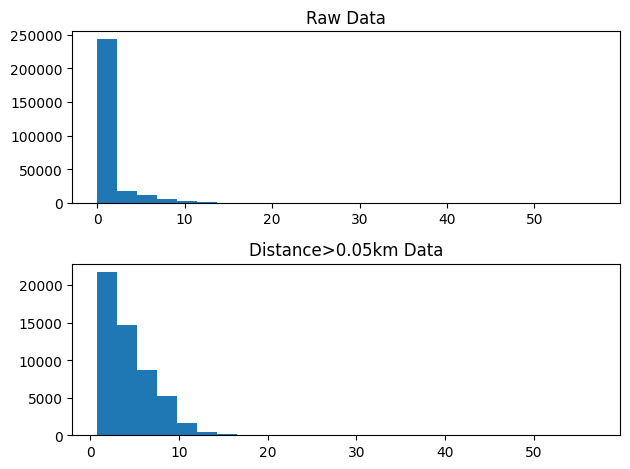

In [43]:
od_restacked = od_reduced.stack().reset_index()
distances_restacked = distances.stack().reset_index()

od_restacked.columns = ['Origin', 'Destination', 'Count']
distances_restacked.columns = ['Origin', 'Destination', 'Distance']

# print(od_restacked.shape)
# print(distances_restacked.shape)

# one of these lines break the origin/destination columns
od_distance = pd.merge(od_restacked, distances_restacked, on=['Origin', 'Destination'])
od_distance_filter = od_distance.loc[od_distance['Distance']>0.05, :]


fig, ax = plt.subplots(nrows=2)
ax[0].hist(od_distance['Distance'], bins=25, weights=od_distance['Count'])
ax[1].hist(od_distance_filter['Distance'], bins=25, weights=od_distance_filter['Count'])

ax[0].set_title('Raw Data')
ax[1].set_title('Distance>0.05km Data')
fig.tight_layout()


In [128]:
def Scatter_Distance_Count(distances, test, model, ax=None):
    """ 
    plots a scatter of distance and counts for original test data and model prediction data
    distances, test, model: pd.DataFrame with columns, index as MSOAs
    ax: plt axis to plot onto
    """

    if ax is None:
        fig, ax = plt.subplots()

    distances = distances.stack().reset_index()
    distances.columns = ['Origin', 'Destination', 'Distance']

    test = test.stack().reset_index()
    test.columns = ['Origin', 'Destination', 'Test']

    model = model.stack().reset_index()
    model.columns = ['Origin', 'Destination', 'Pred']

    df = test.merge(model, on=['Origin', 'Destination']).merge(distances, on=['Origin', 'Destination'])

    ax.scatter(df['Distance'], df['Test'], label='Test', marker='x')
    ax.scatter(df['Distance'], df['Pred'], label='Pred', marker='x')

    return ax



### Q4 - Modelling trip data
Model observed origin-destination matrix with equation

$T_{ij} = c O_i D_j f(d_{ij})$

In [152]:
def Unconstrained_Model(constant,
                        origins,
                        destinations,
                        distances,
                        function,
                        **kwargs):
    """
    constant: c
    origins: O_i, pandas series
    destinations: D_j, pandas series
    distances: d_ij, pandas dataframe
    function: python function f(distances)
    """


    msoas = origins.index.to_list()
    origins = np.asarray(origins).reshape(-1, 1)
    destinations = np.asarray(destinations).reshape(1, -1)
    distances = np.asarray(distances)

    # print(origins.shape)
    # print(destinations.shape)
    # print(distances.shape)
    # print(function(distances).shape)
    
    T = constant * (origins * destinations * function(distances, **kwargs))

    T = pd.DataFrame(T, index=msoas, columns=msoas)

    return T


In [164]:
def f_Constant(distances):
    """ treats distance matrix as constant """
    return distances

def f_Gravity(distances, power=2, alpha=0.001):
    """ inverse square law """


    return 1 / ((distances+alpha) ** power)

In [167]:
# filter o_total, d_total to only have data for which distance is also available
o_total = o_total.loc[o_total.index.isin(distances.columns.to_list())]
d_total = d_total.loc[d_total.index.isin(distances.columns.to_list())]

# also filter distances similarly
distances = distances.loc[distances.index.isin(o_total.index.to_list()),
                          distances.columns.isin(d_total.index.to_list())]

# and od-matrix
od_reduced = od_matrix.loc[od_matrix.index.isin(distances.index.to_list()),
                           od_matrix.columns.isin(distances.index.to_list())]


base_model = Unconstrained_Model(1, o_total, d_total, distances, f_Constant)
gravity_model = Unconstrained_Model(0.0001, o_total, d_total, distances, f_Gravity, power=2)




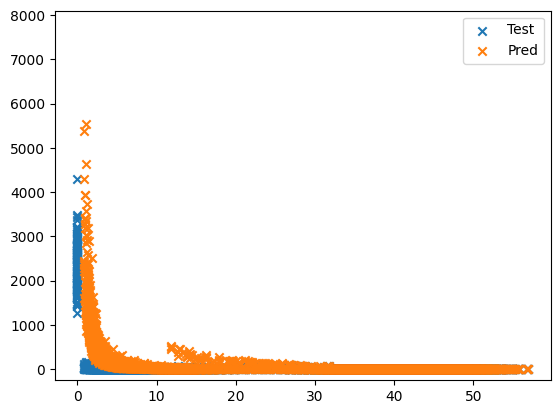

In [175]:
fig, ax = plt.subplots()

ax = Scatter_Distance_Count(distances, od_reduced, gravity_model, ax=ax)

ax.set_ylim([-250, 1*e**9])
_ = ax.legend()